conda activate workenv

# Accept TOS (first time only)
conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/main
conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/r

# Initialize conda
conda init bash
source ~/.bashrc

# Create environment from file
conda env create -f environment.yml

# Activate it
conda activate workenv

In [41]:
# Load exported combined segments CSV
import os
import numpy as np
import pandas as pd

BASE_DATA_DIR = os.path.abspath("../data")
EXPORT_DIR = os.path.join(BASE_DATA_DIR, "export")
VALUES_CSV = os.path.join(EXPORT_DIR, "segments_values.csv")
META_CSV = os.path.join(EXPORT_DIR, "segments_meta.csv")

print("Export dir:", EXPORT_DIR)
print("Values CSV exists:", os.path.exists(VALUES_CSV))
print("Meta CSV exists:", os.path.exists(META_CSV))

df_values = pd.read_csv(VALUES_CSV)
df_meta = pd.read_csv(META_CSV)

# Normalize column names to lowercase for consistent access
df_values.columns = df_values.columns.str.lower()
df_meta.columns = df_meta.columns.str.lower()

print("df_values:", df_values.shape)
print("df_meta:", df_meta.shape)
df_values.head()

Export dir: /work/data/export
Values CSV exists: True
Meta CSV exists: True
df_values: (4951, 8)
df_meta: (221, 5)


,segment_id,label,csv_file,seq_index,open,high,low,close
0,77,Bearish Pennant,GSPC_2025-09-25_to_2025-09-29_5m.csv,0,6670.169922,6671.689941,6669.669922,6671.060059
1,77,Bearish Pennant,GSPC_2025-09-25_to_2025-09-29_5m.csv,1,6671.100098,6671.370117,6668.310059,6668.370117
2,77,Bearish Pennant,GSPC_2025-09-25_to_2025-09-29_5m.csv,2,6668.450195,6668.529785,6663.020020,6663.279785
3,77,Bearish Pennant,GSPC_2025-09-25_to_2025-09-29_5m.csv,3,6663.169922,6663.169922,6658.319824,6661.779785
4,77,Bearish Pennant,GSPC_2025-09-25_to_2025-09-29_5m.csv,4,6661.759766,6665.299805,6659.799805,6662.270020


In [42]:
# Create train/test split at segment level (90/10 split)
from sklearn.model_selection import train_test_split

# Get unique segment IDs
unique_segments = df_values['segment_id'].unique()
print(f"Total segments: {len(unique_segments)}")

# Split segment IDs into train and test (stratified by label)
segment_labels = df_values.groupby('segment_id')['label'].first()
train_seg_ids, test_seg_ids = train_test_split(
    unique_segments, 
    test_size=0.10, 
    random_state=11,
    stratify=segment_labels
)

print(f"Train segments: {len(train_seg_ids)}")
print(f"Test segments: {len(test_seg_ids)}")

# Split the data
df_values_train = df_values[df_values['segment_id'].isin(train_seg_ids)].copy()
df_values_test = df_values[df_values['segment_id'].isin(test_seg_ids)].copy()

print(f"\nTrain data shape: {df_values_train.shape}")
print(f"Test data shape: {df_values_test.shape}")

# Verify label distribution
print("\nTrain label distribution:")
print(df_values_train.groupby('segment_id')['label'].first().value_counts())
print("\nTest label distribution:")
print(df_values_test.groupby('segment_id')['label'].first().value_counts())

# Save test set raw data for baseline model evaluation
TEST_RAW_CSV = os.path.join(EXPORT_DIR, "segments_test_raw.csv")
df_values_test.to_csv(TEST_RAW_CSV, index=False)
print(f"\nSaved test raw data: {TEST_RAW_CSV}")

Total segments: 144
Train segments: 129
Test segments: 15

Train data shape: (4527, 8)
Test data shape: (424, 8)

Train label distribution:
label
Bullish Normal     36
Bearish Normal     24
Bearish Pennant    23
Bullish Pennant    20
Bearish Wedge      13
Bullish Wedge      13
Name: count, dtype: int64

Test label distribution:
label
Bullish Normal     4
Bearish Pennant    3
Bearish Normal     3
Bullish Wedge      2
Bullish Pennant    2
Bearish Wedge      1
Name: count, dtype: int64

Saved test raw data: /work/data/export/segments_test_raw.csv


In [43]:
# Per-datapoint normalization and feature engineering (rolling + per-step)
from typing import List
import numpy as np
import pandas as pd

NUM_COLS = [c for c in ["open","high","low","close"] if c in df_values_train.columns]
assert set(["segment_id","label","csv_file","seq_index"]).issubset(df_values_train.columns), "Required columns missing in values CSV"
assert len(NUM_COLS) >= 1, "No OHLC columns found"

WINDOW = 5  # rolling window for per-step volatility features
EPS = 1e-9

def minmax_norm(s: pd.Series) -> pd.Series:
    vmin = s.min()
    vmax = s.max()
    if pd.isna(vmin) or pd.isna(vmax) or vmax == vmin:
        return pd.Series(np.zeros(len(s), dtype=float), index=s.index)
    return (s - vmin) / (vmax - vmin)

def _interp_series(orig_x: np.ndarray, y: np.ndarray, tgt_x: np.ndarray) -> np.ndarray:
    if len(y) == 0:
        return np.zeros(len(tgt_x), dtype=float)
    if len(y) == 1:
        return np.full(len(tgt_x), float(y[0]))
    return np.interp(tgt_x, orig_x, y)

def process_segment(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values("seq_index").reset_index(drop=True)

    # Raw spread for compression ratio (per-step)
    raw_high = g["high"].astype(float) if "high" in g.columns else pd.Series(np.zeros(len(g)))
    raw_low  = g["low"].astype(float)  if "low" in g.columns  else pd.Series(np.zeros(len(g)))
    raw_spread = (raw_high - raw_low).to_numpy()
    start_spread = float(raw_spread[0]) if len(raw_spread) else 0.0
    comp_series = (raw_spread / max(abs(start_spread), EPS)) if len(raw_spread) else np.array([], dtype=float)

    # Normalize OHLC per segment on raw values
    norm = {}
    for c in NUM_COLS:
        norm[f"{c}_norm"] = minmax_norm(g[c].astype(float))
    norm_df = pd.DataFrame(norm)

    # Resample normalized columns and compression ratio to 24 steps
    L = len(g)
    orig_x = np.arange(L, dtype=float) if L > 1 else np.array([0.0])
    tgt_x = np.linspace(0.0, max(0.0, (L - 1.0)), 24)

    resampled = {}
    for col in norm_df.columns:
        y = norm_df[col].astype(float).to_numpy()
        resampled[col] = _interp_series(orig_x, y, tgt_x)

    comp_resampled = _interp_series(orig_x, comp_series, tgt_x)

    out = pd.DataFrame(resampled)

    # Per-datapoint engineered features on resampled normalized series
    close_n = out["close_norm"] if "close_norm" in out.columns else pd.Series(np.zeros(24))
    high_n  = out["high_norm"]  if "high_norm"  in out.columns else pd.Series(np.zeros(24))
    low_n   = out["low_norm"]   if "low_norm"   in out.columns else pd.Series(np.zeros(24))
    open_n  = out["open_norm"]  if "open_norm"  in out.columns else pd.Series(np.zeros(24))

    # Rolling volatility features (per point)
    vol_close = pd.Series(close_n).rolling(WINDOW, min_periods=1).std().fillna(0.0).to_numpy()
    spread_n = (pd.Series(high_n) - pd.Series(low_n)).to_numpy()
    vol_high_low = pd.Series(spread_n).rolling(WINDOW, min_periods=1).mean().fillna(0.0).to_numpy()

    # Per-step compression ratio (from raw spread, resampled) with clipping to [0.2, 3.0]
    compression_ratio = np.clip(comp_resampled, 0.2, 3.0)

    # Per-step trend
    trend = (pd.Series(open_n) - pd.Series(close_n)).to_numpy()

    # Assemble output with metadata
    out.insert(0, "segment_id", int(g["segment_id"].iloc[0]))
    out.insert(1, "label", g["label"].iloc[0])
    out.insert(2, "csv_file", g["csv_file"].iloc[0])
    out["seq_pos"] = np.arange(1, 25, dtype=int)  # 1..24
    out["vol_close"] = vol_close
    out["vol_high_low"] = vol_high_low
    out["compression_ratio"] = compression_ratio
    out["trend"] = trend
    return out

# Process training data
print("Processing training segments...")
groups_train = df_values_train.groupby("segment_id", sort=True)
processed_list_train: List[pd.DataFrame] = [process_segment(g.copy()) for _, g in groups_train]
df_proc_train = pd.concat(processed_list_train, axis=0, ignore_index=True)

# Process test data
print("Processing test segments...")
groups_test = df_values_test.groupby("segment_id", sort=True)
processed_list_test: List[pd.DataFrame] = [process_segment(g.copy()) for _, g in groups_test]
df_proc_test = pd.concat(processed_list_test, axis=0, ignore_index=True)

# Keep normalized OHLC, engineered features, and ids
keep_cols = (["segment_id","label","csv_file","seq_pos"] +
             [f"{c}_norm" for c in NUM_COLS] +
             ["vol_close","vol_high_low","compression_ratio","trend"]) 
# Retain only columns that exist (in case some OHLC missing)
keep_cols = [c for c in keep_cols if c in df_proc_train.columns]

df_proc_train = df_proc_train[keep_cols]
df_proc_test = df_proc_test[keep_cols]

print(f"\nProcessed train shape: {df_proc_train.shape}")
print(f"Processed test shape: {df_proc_test.shape}")

# For backward compatibility, keep df_proc as training data
df_proc = df_proc_train.copy()
df_proc.head()

Processing training segments...
Processing test segments...

Processed train shape: (3096, 12)
Processed test shape: (360, 12)
Processing test segments...

Processed train shape: (3096, 12)
Processed test shape: (360, 12)


,segment_id,label,csv_file,seq_pos,open_norm,high_norm,low_norm,close_norm,vol_close,vol_high_low,compression_ratio,trend
0,77,Bearish Pennant,GSPC_2025-09-25_to_2025-09-29_5m.csv,1,0.933130,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,-0.066870
1,77,Bearish Pennant,GSPC_2025-09-25_to_2025-09-29_5m.csv,2,0.968019,0.987838,0.955038,0.909398,0.064065,0.016400,1.268626,0.058621
2,77,Bearish Pennant,GSPC_2025-09-25_to_2025-09-29_5m.csv,3,0.991717,0.967688,0.899247,0.812058,0.093991,0.033747,1.567593,0.179659
3,77,Bearish Pennant,GSPC_2025-09-25_to_2025-09-29_5m.csv,4,0.892325,0.859674,0.724338,0.640607,0.153789,0.059144,2.200313,0.251719
4,77,Bearish Pennant,GSPC_2025-09-25_to_2025-09-29_5m.csv,5,0.776490,0.735692,0.552680,0.489310,0.205931,0.083918,2.699183,0.287180


In [44]:
# Save preprocessed datasets (train and test) and quick summary
os.makedirs(EXPORT_DIR, exist_ok=True)

# Save training data
PREPROC_CSV = os.path.join(EXPORT_DIR, "segments_preproc_24.csv")
_df_train = df_proc_train.sort_values(["segment_id", "seq_pos"], kind="mergesort").reset_index(drop=True)
_df_train.to_csv(PREPROC_CSV, index=False)
print("Saved training data:", PREPROC_CSV)
print(f"  Rows: {len(_df_train)}, Segments: {_df_train['segment_id'].nunique()}")

# Save test data
PREPROC_TEST_CSV = os.path.join(EXPORT_DIR, "segments_preproc_24_test.csv")
_df_test = df_proc_test.sort_values(["segment_id", "seq_pos"], kind="mergesort").reset_index(drop=True)
_df_test.to_csv(PREPROC_TEST_CSV, index=False)
print("\nSaved test data:", PREPROC_TEST_CSV)
print(f"  Rows: {len(_df_test)}, Segments: {_df_test['segment_id'].nunique()}")

print("\nColumns:", list(_df_train.columns))
print("\nTraining data sample:")
display(_df_train.sample(min(5, len(_df_train)), random_state=0))
print("\nTest data sample:")
display(_df_test.sample(min(5, len(_df_test)), random_state=0))

Saved training data: /work/data/export/segments_preproc_24.csv
  Rows: 3096, Segments: 129

Saved test data: /work/data/export/segments_preproc_24_test.csv
  Rows: 360, Segments: 15

Columns: ['segment_id', 'label', 'csv_file', 'seq_pos', 'open_norm', 'high_norm', 'low_norm', 'close_norm', 'vol_close', 'vol_high_low', 'compression_ratio', 'trend']

Training data sample:


,segment_id,label,csv_file,seq_pos,open_norm,high_norm,low_norm,close_norm,vol_close,vol_high_low,compression_ratio,trend
2307,184,Bearish Pennant,EURUSD_1H_001.csv,4,0.066978,0.100870,0.165602,0.085292,0.411966,0.057362,0.995445,-0.018313
1114,128,Bullish Wedge,EURUSDX_2025-10-25_to_2025-10-29_5m.csv,11,0.818079,0.824024,0.847394,0.814335,0.111762,-0.012250,0.510078,0.003744
1850,162,Bearish Normal,XAUUSD_30min.csv,3,0.052423,0.201842,0.110963,0.220884,0.110442,0.045440,1.221629,-0.168461
989,123,Bullish Pennant,EURUSDX_2025-10-10_to_2025-10-14_5m.csv,6,0.777439,0.763932,0.797674,0.726683,0.308853,0.035362,1.964785,0.050756
678,108,Bearish Pennant,EURUSDX_2025-09-15_to_2025-09-19_5m.csv,7,0.491463,0.478999,0.367570,0.398302,0.199497,-0.034360,1.114309,0.093161



Test data sample:


,segment_id,label,csv_file,seq_pos,open_norm,high_norm,low_norm,close_norm,vol_close,vol_high_low,compression_ratio,trend
6,91,Bearish Pennant,NDX_2025-09-20_to_2025-09-24_5m.csv,7,0.531502,0.568593,0.527798,0.471937,0.137797,0.014934,1.410602,0.059565
223,176,Bullish Normal,EURUSD_1H_001.csv,8,0.708983,0.643641,0.751296,0.649034,0.164242,-0.044669,0.436701,0.059949
106,121,Bearish Pennant,EURUSDX_2025-10-10_to_2025-10-14_5m.csv,11,0.377600,0.338847,0.331606,0.348366,0.115789,-0.029769,1.774691,0.029234
216,176,Bullish Normal,EURUSD_1H_001.csv,1,0.000000,0.000000,0.000000,0.020370,0.000000,0.000000,1.000000,-0.020370
90,117,Bullish Pennant,EURUSDX_2025-09-30_to_2025-10-04_5m.csv,19,0.893050,0.825729,0.884431,0.912859,0.068962,-0.060246,0.553428,-0.019809


df_proc shape: (3096, 12)


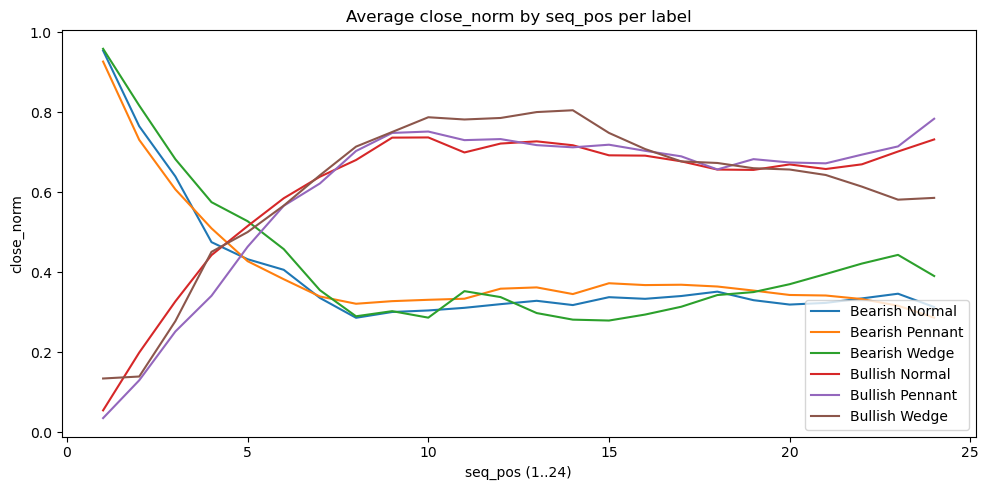

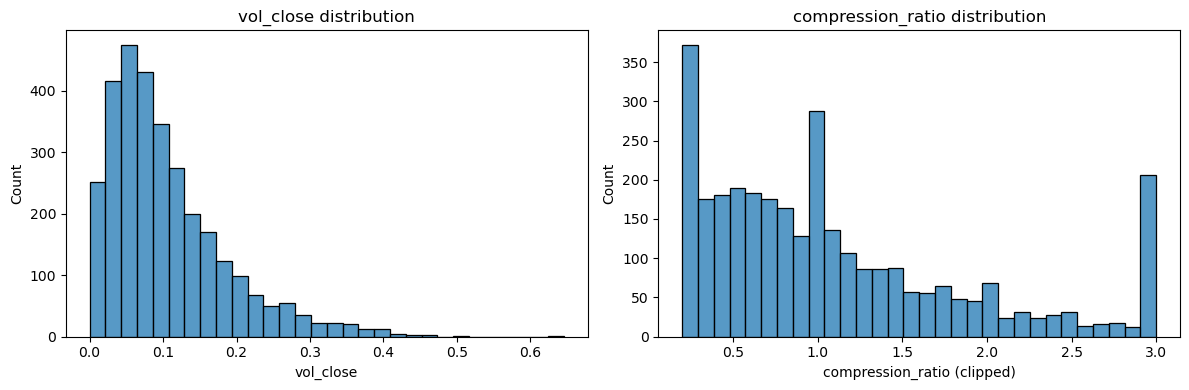

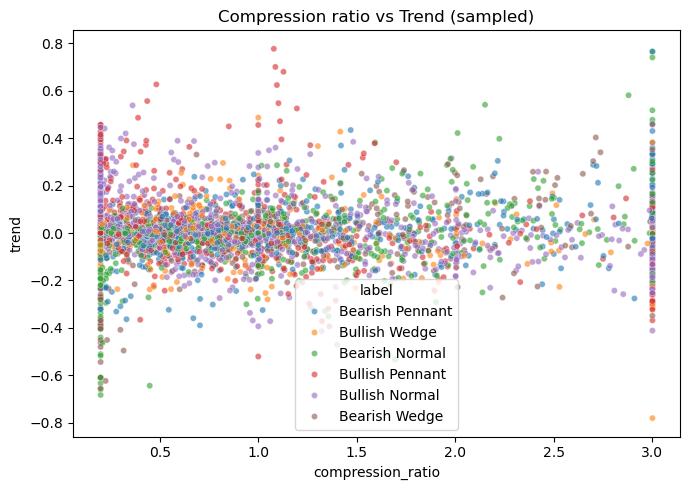

In [45]:
# Visualize engineered features and normalized series
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure df_proc is available; otherwise load from saved CSV
if 'df_proc' not in globals():
    BASE_DATA_DIR = os.path.abspath("../data")
    EXPORT_DIR = os.path.join(BASE_DATA_DIR, "export")
    PREPROC_CSV = os.path.join(EXPORT_DIR, "segments_preproc_24.csv")
    print("Loading preprocessed data from:", PREPROC_CSV)
    df_proc = pd.read_csv(PREPROC_CSV)

print("df_proc shape:", df_proc.shape)
available_cols = set(df_proc.columns)
norm_priority = ["close_norm","open_norm","high_norm","low_norm"]
series_col = next((c for c in norm_priority if c in available_cols), None)
if series_col is None:
    raise ValueError("No normalized OHLC columns found to plot.")

# 1) Plot average normalized price over seq_pos by label
plt.figure(figsize=(10,5))
avg_series = (df_proc.groupby(["label","seq_pos"])[series_col].mean().reset_index())
for lbl, sub in avg_series.groupby("label"):
    plt.plot(sub["seq_pos"], sub[series_col], label=str(lbl))
plt.title(f"Average {series_col} by seq_pos per label")
plt.xlabel("seq_pos (1..24)")
plt.ylabel(series_col)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Distribution of volatility and compression_ratio
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_proc["vol_close"], bins=30, ax=axes[0])
axes[0].set_title("vol_close distribution")
axes[0].set_xlabel("vol_close")

sns.histplot(df_proc["compression_ratio"], bins=30, ax=axes[1])
axes[1].set_title("compression_ratio distribution")
axes[1].set_xlabel("compression_ratio (clipped)")
plt.tight_layout()
plt.show()

# 3) Scatter of compression_ratio vs trend (colored by label)
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_proc.sample(min(len(df_proc), 5000), random_state=0),
                x="compression_ratio", y="trend", hue="label", s=20, alpha=0.6)
plt.title("Compression ratio vs Trend (sampled)")
plt.xlabel("compression_ratio")
plt.ylabel("trend")
plt.tight_layout()
plt.show()

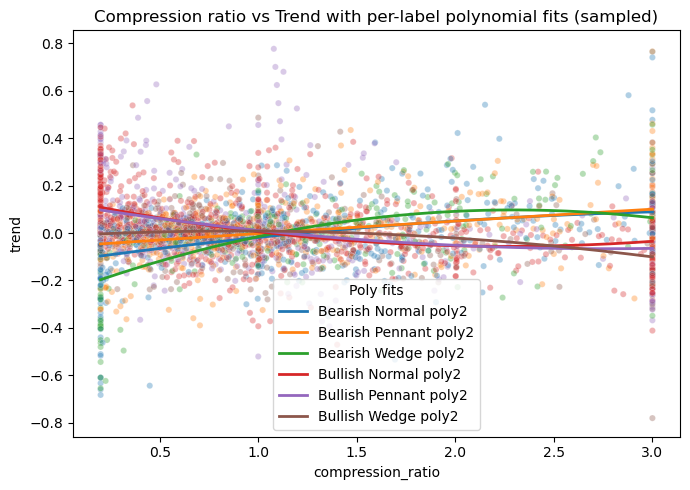

In [46]:
# Polynomial regression lines per label on Compression ratio vs Trend
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Use a sampled subset for speed and visual clarity
samp = df_proc.sample(min(len(df_proc), 5000), random_state=0) if 'df_proc' in globals() else None
if samp is None:
    BASE_DATA_DIR = os.path.abspath("../data")
    EXPORT_DIR = os.path.join(BASE_DATA_DIR, "export")
    PREPROC_CSV = os.path.join(EXPORT_DIR, "segments_preproc_24.csv")
    print("Loading preprocessed data from:", PREPROC_CSV)
    df_proc = pd.read_csv(PREPROC_CSV)
    samp = df_proc.sample(min(len(df_proc), 5000), random_state=0)

deg = 2  # polynomial degree
labels = sorted(samp['label'].dropna().unique())
palette = sns.color_palette(n_colors=len(labels))
label_to_color = {lbl: palette[i] for i, lbl in enumerate(labels)}

x_min = float(samp['compression_ratio'].min())
x_max = float(samp['compression_ratio'].max())
xr = np.linspace(x_min, x_max, 200)

plt.figure(figsize=(7,5))
# scatter without a legend (we'll add a custom legend for fits)
sns.scatterplot(data=samp, x='compression_ratio', y='trend', hue='label', s=20, alpha=0.35, palette=label_to_color, legend=False)

proxies = []
names = []
for lbl in labels:
    sub = samp[samp['label'] == lbl].dropna(subset=['compression_ratio','trend'])
    if len(sub) >= deg + 1:
        coeffs = np.polyfit(sub['compression_ratio'].to_numpy(), sub['trend'].to_numpy(), deg)
        yfit = np.polyval(coeffs, xr)
        plt.plot(xr, yfit, color=label_to_color[lbl], linewidth=2.0)
        proxies.append(Line2D([0], [0], color=label_to_color[lbl], lw=2))
        names.append(f"{lbl} poly{deg}")

plt.title("Compression ratio vs Trend with per-label polynomial fits (sampled)")
plt.xlabel("compression_ratio")
plt.ylabel("trend")
if proxies:
    plt.legend(proxies, names, title="Poly fits", loc="best")
plt.tight_layout()
plt.show()